In [2]:
import os
import pandas as pd

# Path to your image dataset
dataset_dir = r"C:\Users\Ntinos\Desktop\Ntinos\HA\Second_Obliteration\ML\Poke_images\Dataset_types"

# List to store image paths and labels
data = []

# Walk through each folder (type)
for label in os.listdir(dataset_dir):
    label_path = os.path.join(dataset_dir, label)
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                full_path = os.path.join(label_path, file)
                data.append({'image_path': full_path, 'label': label})

# Create DataFrame
df = pd.DataFrame(data)

# Preview
print(df.head())


                                          image_path label
0  C:\Users\Ntinos\Desktop\Ntinos\HA\Second_Oblit...   Bug
1  C:\Users\Ntinos\Desktop\Ntinos\HA\Second_Oblit...   Bug
2  C:\Users\Ntinos\Desktop\Ntinos\HA\Second_Oblit...   Bug
3  C:\Users\Ntinos\Desktop\Ntinos\HA\Second_Oblit...   Bug
4  C:\Users\Ntinos\Desktop\Ntinos\HA\Second_Oblit...   Bug


In [3]:
import os
import random
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from PIL import Image
import torch
from collections import Counter
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.transforms import ToPILImage
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from tqdm import tqdm
warnings.filterwarnings("ignore", category=FutureWarning)
root_dir = os.getcwd()

def fisher_score(X, y):
    classes = np.unique(y)
    overall_mean = np.mean(X, axis=0)
    num, denom = 0, 0
    for cls in classes:
        cls_samples = X[y == cls]
        cls_mean = np.mean(cls_samples, axis=0)
        num += len(cls_samples) * np.sum((cls_mean - overall_mean)**2)
        denom += np.sum((cls_samples - cls_mean)**2)
    return num / denom if denom != 0 else 0


In [4]:
from sklearn.model_selection import train_test_split

# First split: 70% train, 30% temp (val + test)
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df['label'], random_state=42
)

# Second split: ⅔ val (20%), ⅓ test (10%) from temp
val_df, test_df = train_test_split(
    temp_df, test_size=1/3, stratify=temp_df['label'], random_state=42
)

# Optional: Save splits to CSV like Minecraft project
train_df.to_csv("train_set.csv", index=False)
val_df.to_csv("val_set.csv", index=False)
test_df.to_csv("test_set.csv", index=False)

# Summary
dataset_size = len(df)
print("After splitting Pokémon image dataset:")
print(f"Total dataset size: {dataset_size}")
print(f"Training set size: {len(train_df)} ({len(train_df)/dataset_size*100:.2f}%)")
print(f"Validation set size: {len(val_df)} ({len(val_df)/dataset_size*100:.2f}%)")
print(f"Test set size: {len(test_df)} ({len(test_df)/dataset_size*100:.2f}%)")


After splitting Pokémon image dataset:
Total dataset size: 22253
Training set size: 15577 (70.00%)
Validation set size: 4450 (20.00%)
Test set size: 2226 (10.00%)


In [5]:
# Map each label (Pokémon type) to an index
label_mapping = {label: idx for idx, label in enumerate(sorted(df['label'].unique()))}

class PokemonDataset(Dataset):
    def __init__(self, df, transform=None):
        self.img_paths = df['image_path'].tolist()
        self.labels = df['label'].map(label_mapping).tolist()
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, torch.tensor(label, dtype=torch.int64)


In [6]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])


In [7]:
train_set = PokemonDataset(train_df, transform)
val_set = PokemonDataset(val_df, transform)
test_set = PokemonDataset(test_df, transform)

# Extract parent class labels for all samples
labelss = train_set.labels

# Compute class weights
class_counts = Counter(labelss)
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in labelss]

# Set up sampler and DataLoader
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


In [8]:
use_colors = {
    'Fire': 'red',
    'Water': 'blue',
    'Grass': 'green',
    'Electric': 'yellow',
    'Psychic': 'purple',
    'Fighting': 'brown',
    'Poison': 'violet',
    'Ground_Rock': 'saddlebrown',
    'Bug': 'lime',
    'Normal': 'lightgray',
}


In [9]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# ConvAutoencoder definition
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),   # [B, 3, 64, 64] -> [B, 32, 32, 32]
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # -> [B, 64, 16, 16]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(64, 128, 3, stride=2, padding=1), # -> [B, 128, 8, 8]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True)
        )

        self.flatten = nn.Flatten()
        self.fc_latent = nn.Linear(128 * 8 * 8, 64)
        self.fc_unflatten = nn.Linear(64, 128 * 8 * 8)

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),

            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True),

            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder_conv(x)
        x = self.flatten(x)
        z = self.fc_latent(x)
        x = self.fc_unflatten(z)
        x = x.view(-1, 128, 8, 8)
        x = self.decoder_conv(x)
        return x


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

autoencoder = ConvAutoencoder().to(device)
autoencoder.load_state_dict(torch.load("checkpoints/best_model.pth", map_location=device))
autoencoder.eval()

ConvAutoencoder(
  (encoder_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_latent): Linear(in_features=8192, out_features=64, bias=True)
  (fc_unflatten): Linear(in_features=64, out_features=8192, bias=True)
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1

In [11]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes, use_autoencoder=False, autoencoder=None, freeze_encoder=True):
        super(CNNClassifier, self).__init__()
        self.use_autoencoder = use_autoencoder
        self.autoencoder = autoencoder

        if use_autoencoder and autoencoder is not None:
            # Use the encoder from the pretrained autoencoder
            if freeze_encoder:
                for param in autoencoder.parameters():
                    param.requires_grad = False

            self.encoder_conv = autoencoder.encoder_conv
            self.flatten = autoencoder.flatten
            self.fc_latent = autoencoder.fc_latent
            in_features = 64  # latent dim
        else:
            # Use a standard CNN feature extractor
            self.feature_extractor = nn.Sequential(
                nn.Conv2d(3, 32, 3, stride=1, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),  # 32x32x32

                nn.Conv2d(32, 64, 3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),  # 64x16x16

                nn.Conv2d(64, 128, 3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),  # 128x8x8

                nn.Flatten()
            )
            in_features = 128 * 8 * 8

        # Shared classifier head
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        if self.use_autoencoder and self.autoencoder is not None:
            with torch.no_grad():
                x = self.encoder_conv(x)
                x = self.flatten(x)
                x = self.fc_latent(x)
        else:
            x = self.feature_extractor(x)

        x = self.classifier(x)
        return x


# CNNClassifier Architectures: With and Without Autoencoder

## With Autoencoder (`use_autoencoder=True`)

- The input image is passed through the **encoder** part of the `ConvAutoencoder`.
- The encoder compresses the image into a **64-dimensional latent vector**.
- This 64-D vector is then fed into a classifier (a small MLP).
- The classifier's input layer has **64 features**.

**Flow:**  
`image → autoencoder encoder → 64-D latent vector → classifier`

---

## Without Autoencoder (`use_autoencoder=False`)

- The input image is passed through a **standard CNN feature extractor** (defined in `CNNClassifier`).
- The CNN consists of several `Conv2d`, `BatchNorm2d`, `ReLU`, and `MaxPool2d` layers, followed by flattening.
- The output is an **8192-dimensional feature vector** (`128 × 8 × 8`).
- This vector is passed to the classifier (MLP).
- The classifier's input layer has **8192 features**.

**Flow:**  
`image → CNN feature extractor → 8192-D feature vector → classifier`

---

## Summary Table

| Mode                | Feature Extractor         | Feature Size | Classifier Input |
|---------------------|--------------------------|--------------|------------------|
| With Autoencoder    | Autoencoder Encoder      | 64           | 64               |
| Without Autoencoder | Standard CNN Extractor   | 8192         | 8192             |

In [12]:
# Train an MLP classifier on autoencoder features for 100 epochs with early stopping and save every 10 epochs

num_classes = len(label_mapping)
mlp = CNNClassifier(num_classes=num_classes, use_autoencoder=True, autoencoder=autoencoder).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=1e-3)
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0
num_epochs = 100

train_losses, val_losses = [], []

# MLP

In [ ]:
# for epoch in range(num_epochs):
#     mlp.train()
#     running_loss = 0.0
#     for imgs, labels_batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
#         imgs, labels_batch = imgs.to(device), labels_batch.to(device)
#         optimizer.zero_grad()
#         outputs = mlp(imgs)
#         loss = criterion(outputs, labels_batch)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item() * imgs.size(0)
#     train_loss = running_loss / len(train_loader.dataset)
#     train_losses.append(train_loss)

#     # Validation
#     mlp.eval()
#     val_running_loss = 0.0
#     with torch.no_grad():
#         for imgs, labels_batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
#             imgs, labels_batch = imgs.to(device), labels_batch.to(device)
#             outputs = mlp(imgs)
#             loss = criterion(outputs, labels_batch)
#             val_running_loss += loss.item() * imgs.size(0)
#     val_loss = val_running_loss / len(val_loader.dataset)
#     val_losses.append(val_loss)

#     print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

#     # Save every 10 epochs
#     if (epoch + 1) % 10 == 0:
#         torch.save(mlp.state_dict(), os.path.join(root_dir, 'checkpoints', f'mlp_epoch_{epoch+1}.pth'))

#     # Early stopping
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         epochs_no_improve = 0
#         torch.save(mlp.state_dict(), os.path.join(root_dir, 'checkpoints', 'best_mlp.pth'))
#     else:
#         epochs_no_improve += 1
#         if epochs_no_improve >= patience:
#             print("Early stopping triggered.")
#             break

# # Save losses to JSON
# loss_dict = {"train_losses": train_losses, "val_losses": val_losses}
# with open(os.path.join(root_dir, 'checkpoints', 'mlp_losses.json'), 'w') as f:
#     json.dump(loss_dict, f)


Epoch 1 [Train]:   0%|          | 0/244 [00:00<?, ?it/s]c:\Users\Ntinos\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1 [Val]: 100%|██████████| 70/70 [00:39<00:00,  1.78it/s]


Epoch 1: train_loss=2.3030, val_loss=1.7116


Epoch 2 [Val]: 100%|██████████| 70/70 [00:37<00:00,  1.89it/s]


Epoch 2: train_loss=1.7327, val_loss=1.6003


Epoch 3 [Val]: 100%|██████████| 70/70 [00:36<00:00,  1.93it/s]


Epoch 3: train_loss=1.6280, val_loss=1.5279


Epoch 4 [Val]: 100%|██████████| 70/70 [00:36<00:00,  1.93it/s]


Epoch 4: train_loss=1.5558, val_loss=1.4859


Epoch 5 [Val]: 100%|██████████| 70/70 [00:36<00:00,  1.94it/s]


Epoch 5: train_loss=1.5034, val_loss=1.4514


Epoch 6 [Val]: 100%|██████████| 70/70 [00:35<00:00,  1.96it/s]


Epoch 6: train_loss=1.4589, val_loss=1.4269


Epoch 7 [Val]: 100%|██████████| 70/70 [00:35<00:00,  1.94it/s]


Epoch 7: train_loss=1.4296, val_loss=1.4037


Epoch 8 [Val]: 100%|██████████| 70/70 [00:33<00:00,  2.07it/s]


Epoch 8: train_loss=1.3998, val_loss=1.4017


Epoch 9 [Val]: 100%|██████████| 70/70 [00:35<00:00,  2.00it/s]


Epoch 9: train_loss=1.3801, val_loss=1.3840


Epoch 10 [Val]: 100%|██████████| 70/70 [00:36<00:00,  1.90it/s]


Epoch 10: train_loss=1.3646, val_loss=1.3877


Epoch 11 [Val]: 100%|██████████| 70/70 [00:35<00:00,  1.97it/s]


Epoch 11: train_loss=1.3434, val_loss=1.3789


Epoch 12 [Val]: 100%|██████████| 70/70 [00:36<00:00,  1.94it/s]


Epoch 12: train_loss=1.3288, val_loss=1.3650


Epoch 13 [Val]: 100%|██████████| 70/70 [00:34<00:00,  2.03it/s]


Epoch 13: train_loss=1.3191, val_loss=1.3584


Epoch 14 [Val]: 100%|██████████| 70/70 [00:33<00:00,  2.08it/s]


Epoch 14: train_loss=1.3199, val_loss=1.3512


Epoch 15 [Val]: 100%|██████████| 70/70 [00:33<00:00,  2.07it/s]


Epoch 15: train_loss=1.3097, val_loss=1.3572


Epoch 16 [Val]: 100%|██████████| 70/70 [00:33<00:00,  2.08it/s]


Epoch 16: train_loss=1.3041, val_loss=1.3422


Epoch 17 [Val]: 100%|██████████| 70/70 [00:33<00:00,  2.09it/s]


Epoch 17: train_loss=1.2912, val_loss=1.3514


Epoch 18 [Val]: 100%|██████████| 70/70 [00:33<00:00,  2.08it/s]


Epoch 18: train_loss=1.2894, val_loss=1.3451


Epoch 19 [Val]: 100%|██████████| 70/70 [00:33<00:00,  2.07it/s]


Epoch 19: train_loss=1.2772, val_loss=1.3494


Epoch 20 [Val]: 100%|██████████| 70/70 [00:33<00:00,  2.07it/s]


Epoch 20: train_loss=1.2776, val_loss=1.3645


Epoch 21 [Val]: 100%|██████████| 70/70 [00:33<00:00,  2.08it/s]


Epoch 21: train_loss=1.2694, val_loss=1.3454


Epoch 22 [Val]: 100%|██████████| 70/70 [00:33<00:00,  2.08it/s]


Epoch 22: train_loss=1.2529, val_loss=1.3404


Epoch 23 [Val]: 100%|██████████| 70/70 [00:33<00:00,  2.10it/s]


Epoch 23: train_loss=1.2556, val_loss=1.3466


Epoch 24 [Val]: 100%|██████████| 70/70 [00:33<00:00,  2.07it/s]


Epoch 24: train_loss=1.2352, val_loss=1.3411


Epoch 25 [Val]: 100%|██████████| 70/70 [00:33<00:00,  2.09it/s]


Epoch 25: train_loss=1.2487, val_loss=1.3335


Epoch 26 [Val]: 100%|██████████| 70/70 [00:33<00:00,  2.09it/s]


Epoch 26: train_loss=1.2475, val_loss=1.3352


Epoch 27 [Val]: 100%|██████████| 70/70 [00:33<00:00,  2.10it/s]


Epoch 27: train_loss=1.2397, val_loss=1.3215


Epoch 28 [Val]: 100%|██████████| 70/70 [00:33<00:00,  2.08it/s]


Epoch 28: train_loss=1.2440, val_loss=1.3426


Epoch 29 [Val]: 100%|██████████| 70/70 [00:33<00:00,  2.08it/s]


Epoch 29: train_loss=1.2298, val_loss=1.3510


Epoch 30 [Val]: 100%|██████████| 70/70 [00:33<00:00,  2.09it/s]


Epoch 30: train_loss=1.2172, val_loss=1.3447


Epoch 31 [Val]: 100%|██████████| 70/70 [00:33<00:00,  2.08it/s]


Epoch 31: train_loss=1.2201, val_loss=1.3414


Epoch 32 [Val]: 100%|██████████| 70/70 [00:33<00:00,  2.09it/s]


Epoch 32: train_loss=1.2167, val_loss=1.3371


Epoch 33 [Val]: 100%|██████████| 70/70 [00:33<00:00,  2.09it/s]


Epoch 33: train_loss=1.2286, val_loss=1.3506


Epoch 34 [Val]: 100%|██████████| 70/70 [00:33<00:00,  2.08it/s]


Epoch 34: train_loss=1.2113, val_loss=1.3329


Epoch 35 [Val]: 100%|██████████| 70/70 [00:33<00:00,  2.09it/s]


Epoch 35: train_loss=1.2146, val_loss=1.3553


Epoch 36 [Val]: 100%|██████████| 70/70 [00:33<00:00,  2.08it/s]


Epoch 36: train_loss=1.2001, val_loss=1.3298


Epoch 37 [Val]: 100%|██████████| 70/70 [00:33<00:00,  2.08it/s]

Epoch 37: train_loss=1.1989, val_loss=1.3488
Early stopping triggered.


In [13]:
# Load the best MLP model
mlp.load_state_dict(torch.load(os.path.join(root_dir, 'checkpoints', 'best_mlp.pth'), map_location=device))
mlp.to(device)
mlp.eval()

# Load training and validation losses
with open(os.path.join(root_dir, 'checkpoints', 'mlp_losses.json'), 'r') as f:
    loss_dict = json.load(f)
train_losses = loss_dict["train_losses"]
val_losses = loss_dict["val_losses"]


In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Evaluate the best MLP model on the test set
all_preds = []
all_labels = []
mlp.eval()
test_running_loss = 0.0
with torch.no_grad():
    for imgs, labels_batch in tqdm(test_loader, desc="MLP Test"):
        imgs, labels_batch = imgs.to(device), labels_batch.to(device)
        outputs = mlp(imgs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())
        loss = criterion(outputs, labels_batch)
        test_running_loss += loss.item() * imgs.size(0)
test_loss = test_running_loss / len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f}")

# Compute metrics
acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.4f}")

print("Classification Report:")
mlp_report = classification_report(
    all_labels,
    all_preds,
    target_names=[label_mapping[k] for k in sorted(label_mapping.keys())],
    output_dict=True
)
print(json.dumps(mlp_report, indent=4))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


MLP Test:   6%|▌         | 2/35 [00:01<00:18,  1.74it/s]c:\Users\Ntinos\anaconda3\Lib\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
MLP Test: 100%|██████████| 35/35 [00:15<00:00,  2.28it/s]

Test Loss: 1.2633
Test Accuracy: 0.5872
Classification Report:
{
    "0": {
        "precision": 0.4731182795698925,
        "recall": 0.5641025641025641,
        "f1-score": 0.5146198830409356,
        "support": 156.0
    },
    "1": {
        "precision": 0.7111111111111111,
        "recall": 0.4129032258064516,
        "f1-score": 0.5224489795918368,
        "support": 155.0
    },
    "2": {
        "precision": 0.578125,
        "recall": 0.3394495412844037,
        "f1-score": 0.4277456647398844,
        "support": 109.0
    },
    "3": {
        "precision": 0.5924528301886792,
        "recall": 0.6885964912280702,
        "f1-score": 0.6369168356997972,
        "support": 228.0
    },
    "4": {
        "precision": 0.6460176991150443,
        "recall": 0.5934959349593496,
        "f1-score": 0.6186440677966102,
        "support": 123.0
    },
    "5": {
        "precision": 0.5217391304347826,
        "recall": 0.4077669902912621,
        "f1-score": 0.45776566757493187,
    

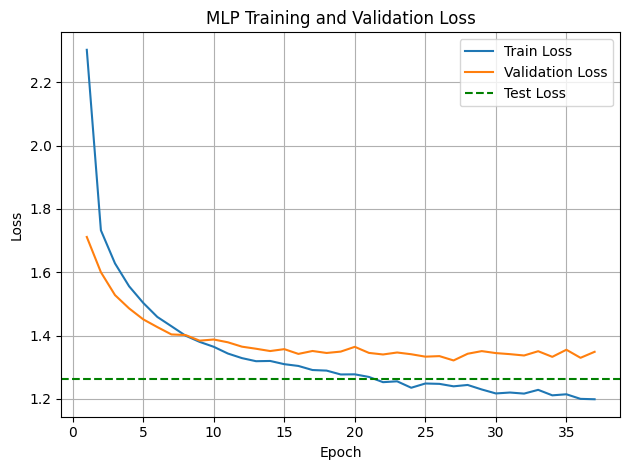

In [15]:
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.axhline(y=test_loss, color='green', linestyle='--', label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
# Train a standard CNN classifier (without autoencoder) for 100 epochs with early stopping and save every 10 epochs
cnn = CNNClassifier(num_classes=len(label_mapping), use_autoencoder=False).to(device)

criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(cnn.parameters(), lr=1e-3)
patience_cnn = 10
best_val_loss_cnn = float('inf')
epochs_no_improve_cnn = 0
num_epochs_cnn = 100

train_losses_cnn, val_losses_cnn = [], []


# CNN

In [ ]:
# for epoch in range(num_epochs_cnn):
#     cnn.train()
#     running_loss = 0.0
#     for imgs, labels_batch in tqdm(train_loader, desc=f"[CNN] Epoch {epoch+1} [Train]"):
#         imgs, labels_batch = imgs.to(device), labels_batch.to(device)
#         optimizer_cnn.zero_grad()
#         outputs = cnn(imgs)
#         loss = criterion_cnn(outputs, labels_batch)
#         loss.backward()
#         optimizer_cnn.step()
#         running_loss += loss.item() * imgs.size(0)
#     train_loss = running_loss / len(train_loader.dataset)
#     train_losses_cnn.append(train_loss)

#     # Validation
#     cnn.eval()
#     val_running_loss = 0.0
#     with torch.no_grad():
#         for imgs, labels_batch in tqdm(val_loader, desc=f"[CNN] Epoch {epoch+1} [Val]"):
#             imgs, labels_batch = imgs.to(device), labels_batch.to(device)
#             outputs = cnn(imgs)
#             loss = criterion_cnn(outputs, labels_batch)
#             val_running_loss += loss.item() * imgs.size(0)
#     val_loss = val_running_loss / len(val_loader.dataset)
#     val_losses_cnn.append(val_loss)

#     print(f"[CNN] Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

#     # Save every 10 epochs
#     if (epoch + 1) % 10 == 0:
#         torch.save(cnn.state_dict(), os.path.join(root_dir, 'checkpoints', f'cnn_epoch_{epoch+1}.pth'))

#     # Early stopping
#     if val_loss < best_val_loss_cnn:
#         best_val_loss_cnn = val_loss
#         epochs_no_improve_cnn = 0
#         torch.save(cnn.state_dict(), os.path.join(root_dir, 'checkpoints', 'best_cnn.pth'))
#     else:
#         epochs_no_improve_cnn += 1
#         if epochs_no_improve_cnn >= patience_cnn:
#             print("[CNN] Early stopping triggered.")
#             break

# # Save losses to JSON
# loss_dict_cnn = {"train_losses": train_losses_cnn, "val_losses": val_losses_cnn}
# with open(os.path.join(root_dir, 'checkpoints', 'cnn_losses.json'), 'w') as f:
#     json.dump(loss_dict_cnn, f)


[CNN] Epoch 1 [Train]:   0%|          | 0/244 [00:00<?, ?it/s]c:\Users\Ntinos\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
[CNN] Epoch 1 [Val]: 100%|██████████| 70/70 [00:41<00:00,  1.70it/s]


[CNN] Epoch 1: train_loss=1.7403, val_loss=1.4915


[CNN] Epoch 2 [Val]: 100%|██████████| 70/70 [00:40<00:00,  1.73it/s]


[CNN] Epoch 2: train_loss=1.3924, val_loss=1.2518


[CNN] Epoch 3 [Val]: 100%|██████████| 70/70 [00:39<00:00,  1.76it/s]


[CNN] Epoch 3: train_loss=1.2196, val_loss=1.0221


[CNN] Epoch 4 [Val]: 100%|██████████| 70/70 [00:40<00:00,  1.73it/s]


[CNN] Epoch 4: train_loss=1.1116, val_loss=1.0678


[CNN] Epoch 5 [Val]: 100%|██████████| 70/70 [00:39<00:00,  1.77it/s]


[CNN] Epoch 5: train_loss=1.0136, val_loss=0.9016


[CNN] Epoch 6 [Val]: 100%|██████████| 70/70 [00:39<00:00,  1.77it/s]


[CNN] Epoch 6: train_loss=0.9338, val_loss=0.8338


[CNN] Epoch 7 [Val]: 100%|██████████| 70/70 [00:39<00:00,  1.77it/s]


[CNN] Epoch 7: train_loss=0.8588, val_loss=0.8225


[CNN] Epoch 8 [Val]: 100%|██████████| 70/70 [00:39<00:00,  1.78it/s]


[CNN] Epoch 8: train_loss=0.7925, val_loss=0.7510


[CNN] Epoch 9 [Val]: 100%|██████████| 70/70 [00:39<00:00,  1.78it/s]


[CNN] Epoch 9: train_loss=0.7188, val_loss=0.7565


[CNN] Epoch 10 [Val]: 100%|██████████| 70/70 [00:39<00:00,  1.77it/s]


[CNN] Epoch 10: train_loss=0.6673, val_loss=0.7102


[CNN] Epoch 11 [Val]: 100%|██████████| 70/70 [00:39<00:00,  1.78it/s]


[CNN] Epoch 11: train_loss=0.6163, val_loss=0.6686


[CNN] Epoch 12 [Val]: 100%|██████████| 70/70 [00:40<00:00,  1.73it/s]


[CNN] Epoch 12: train_loss=0.5601, val_loss=0.7619


[CNN] Epoch 13 [Val]: 100%|██████████| 70/70 [00:40<00:00,  1.73it/s]


[CNN] Epoch 13: train_loss=0.5301, val_loss=0.6046


[CNN] Epoch 14 [Val]: 100%|██████████| 70/70 [00:40<00:00,  1.73it/s]


[CNN] Epoch 14: train_loss=0.4871, val_loss=0.6321


[CNN] Epoch 15 [Val]: 100%|██████████| 70/70 [00:39<00:00,  1.77it/s]


[CNN] Epoch 15: train_loss=0.4413, val_loss=0.6205


[CNN] Epoch 16 [Val]: 100%|██████████| 70/70 [00:39<00:00,  1.76it/s]


[CNN] Epoch 16: train_loss=0.4231, val_loss=0.5693


[CNN] Epoch 17 [Val]: 100%|██████████| 70/70 [00:39<00:00,  1.77it/s]


[CNN] Epoch 17: train_loss=0.3871, val_loss=0.5843


[CNN] Epoch 18 [Val]: 100%|██████████| 70/70 [00:39<00:00,  1.78it/s]


[CNN] Epoch 18: train_loss=0.3649, val_loss=0.6066


[CNN] Epoch 19 [Val]: 100%|██████████| 70/70 [00:40<00:00,  1.72it/s]


[CNN] Epoch 19: train_loss=0.3391, val_loss=0.6743


[CNN] Epoch 20 [Val]: 100%|██████████| 70/70 [00:39<00:00,  1.77it/s]


[CNN] Epoch 20: train_loss=0.3223, val_loss=0.5587


[CNN] Epoch 21 [Val]: 100%|██████████| 70/70 [00:39<00:00,  1.77it/s]


[CNN] Epoch 21: train_loss=0.2913, val_loss=0.6238


[CNN] Epoch 22 [Val]: 100%|██████████| 70/70 [00:39<00:00,  1.77it/s]


[CNN] Epoch 22: train_loss=0.2787, val_loss=0.6061


[CNN] Epoch 23 [Val]: 100%|██████████| 70/70 [00:39<00:00,  1.77it/s]


[CNN] Epoch 23: train_loss=0.2816, val_loss=0.7054


[CNN] Epoch 24 [Val]: 100%|██████████| 70/70 [00:39<00:00,  1.78it/s]


[CNN] Epoch 24: train_loss=0.2472, val_loss=0.6113


[CNN] Epoch 25 [Val]: 100%|██████████| 70/70 [00:39<00:00,  1.77it/s]


[CNN] Epoch 25: train_loss=0.2529, val_loss=0.5916


[CNN] Epoch 26 [Val]: 100%|██████████| 70/70 [00:39<00:00,  1.77it/s]


[CNN] Epoch 26: train_loss=0.2352, val_loss=0.6234


[CNN] Epoch 27 [Val]: 100%|██████████| 70/70 [00:40<00:00,  1.73it/s]


[CNN] Epoch 27: train_loss=0.2155, val_loss=0.6385


[CNN] Epoch 28 [Val]: 100%|██████████| 70/70 [00:39<00:00,  1.75it/s]


[CNN] Epoch 28: train_loss=0.2129, val_loss=0.7118


[CNN] Epoch 29 [Val]: 100%|██████████| 70/70 [00:39<00:00,  1.77it/s]


[CNN] Epoch 29: train_loss=0.2141, val_loss=0.6823


[CNN] Epoch 30 [Val]: 100%|██████████| 70/70 [00:39<00:00,  1.77it/s]

[CNN] Epoch 30: train_loss=0.2047, val_loss=0.7620
[CNN] Early stopping triggered.


In [17]:
# Load the best CNN model
cnn.load_state_dict(torch.load(os.path.join(root_dir, 'checkpoints', 'best_cnn.pth'), map_location=device))
cnn.eval()

# Evaluate the best CNN model on the test set
all_preds_cnn = []
all_labels_cnn = []
test_running_loss_cnn = 0.0
with torch.no_grad():
    for imgs, labels_batch in tqdm(test_loader, desc="CNN Test"):
        imgs, labels_batch = imgs.to(device), labels_batch.to(device)
        outputs = cnn(imgs)
        preds = torch.argmax(outputs, dim=1)
        all_preds_cnn.extend(preds.cpu().numpy())
        all_labels_cnn.extend(labels_batch.cpu().numpy())
        loss = criterion_cnn(outputs, labels_batch)
        test_running_loss_cnn += loss.item() * imgs.size(0)
test_loss_cnn = test_running_loss_cnn / len(test_loader.dataset)

# Compute metrics
acc_cnn = accuracy_score(all_labels_cnn, all_preds_cnn)
print(f"[CNN] Test Accuracy: {acc_cnn:.4f}")

# Classification report
print("[CNN] Classification Report:")
cnn_report = classification_report(
    all_labels_cnn,
    all_preds_cnn,
    target_names=[label_mapping[k] for k in sorted(label_mapping)],
    output_dict=True
)
print(json.dumps(cnn_report, indent=4))

# Confusion matrix
print("[CNN] Confusion Matrix:")
print(confusion_matrix(all_labels_cnn, all_preds_cnn))


CNN Test:   6%|▌         | 2/35 [00:01<00:19,  1.71it/s]c:\Users\Ntinos\anaconda3\Lib\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
CNN Test: 100%|██████████| 35/35 [00:15<00:00,  2.24it/s]

[CNN] Test Accuracy: 0.8360
[CNN] Classification Report:
{
    "0": {
        "precision": 0.7409638554216867,
        "recall": 0.7884615384615384,
        "f1-score": 0.7639751552795031,
        "support": 156.0
    },
    "1": {
        "precision": 0.8741258741258742,
        "recall": 0.8064516129032258,
        "f1-score": 0.8389261744966443,
        "support": 155.0
    },
    "2": {
        "precision": 0.8783783783783784,
        "recall": 0.5963302752293578,
        "f1-score": 0.7103825136612022,
        "support": 109.0
    },
    "3": {
        "precision": 0.8728070175438597,
        "recall": 0.8728070175438597,
        "f1-score": 0.8728070175438597,
        "support": 228.0
    },
    "4": {
        "precision": 0.9196428571428571,
        "recall": 0.8373983739837398,
        "f1-score": 0.8765957446808511,
        "support": 123.0
    },
    "5": {
        "precision": 0.7875647668393783,
        "recall": 0.7378640776699029,
        "f1-score": 0.7619047619047619,
 

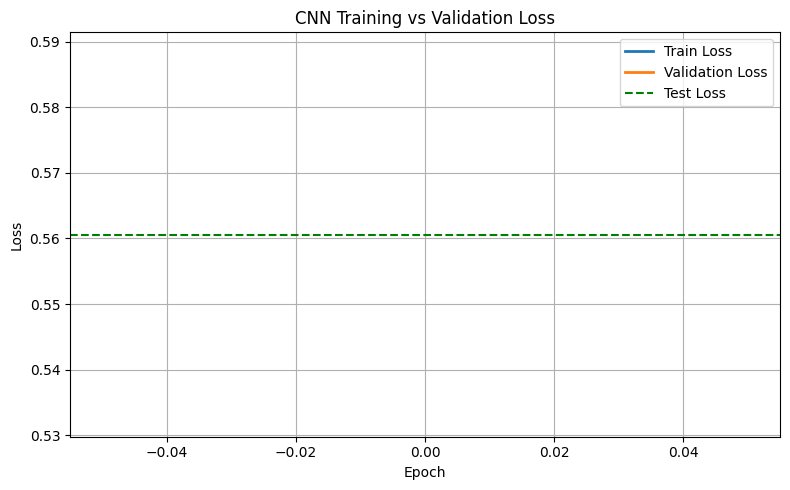

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses_cnn) + 1), train_losses_cnn, label="Train Loss", linewidth=2)
plt.plot(range(1, len(val_losses_cnn) + 1), val_losses_cnn, label="Validation Loss", linewidth=2)
plt.axhline(y=test_loss_cnn, color='green', linestyle='--', label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
# Construct comparison rows
rows = []
for cls in label_mapping.keys():
    mlp_cls_f1 = mlp_report.get(cls, {}).get("f1-score", 0.0)
    cnn_cls_f1 = cnn_report.get(cls, {}).get("f1-score", 0.0)
    diff = mlp_cls_f1 - cnn_cls_f1
    rows.append({
        "Class": cls,
        "MLP (Autoencoder F1)": f"{mlp_cls_f1:.4f}",
        "CNN (Standard F1)": f"{cnn_cls_f1:.4f}",
        "Difference": f"{diff:+.4f}"
    })

# Macro average F1-score comparison
mlp_f1 = mlp_report.get("macro avg", {}).get("f1-score", 0.0)
cnn_f1 = cnn_report.get("macro avg", {}).get("f1-score", 0.0)
rows.append({
    "Class": "Macro Avg",
    "MLP (Autoencoder F1)": f"{mlp_f1:.4f}",
    "CNN (Standard F1)": f"{cnn_f1:.4f}",
    "Difference": f"{mlp_f1 - cnn_f1:+.4f}"
})

# Accuracy comparison
mlp_acc = accuracy_score(all_labels, all_preds)
cnn_acc = accuracy_score(all_labels_cnn, all_preds_cnn)
rows.append({
    "Class": "Accuracy",
    "MLP (Autoencoder F1)": f"{mlp_acc:.4f}",
    "CNN (Standard F1)": f"{cnn_acc:.4f}",
    "Difference": f"{mlp_acc - cnn_acc:+.4f}"
})

# Convert to DataFrame and display
results_df = pd.DataFrame(rows)
print(results_df.to_string(index=False))  # Use display() if in Jupyter


      Class MLP (Autoencoder F1) CNN (Standard F1) Difference
        Bug               0.0000            0.0000    +0.0000
   Electric               0.0000            0.0000    +0.0000
   Fighting               0.0000            0.0000    +0.0000
       Fire               0.0000            0.0000    +0.0000
      Grass               0.0000            0.0000    +0.0000
Ground_Rock               0.0000            0.0000    +0.0000
     Normal               0.0000            0.0000    +0.0000
     Poison               0.0000            0.0000    +0.0000
    Psychic               0.0000            0.0000    +0.0000
      Water               0.0000            0.0000    +0.0000
  Macro Avg               0.5580            0.8230    -0.2650
   Accuracy               0.5872            0.8360    -0.2489


c:\Users\Ntinos\anaconda3\Lib\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


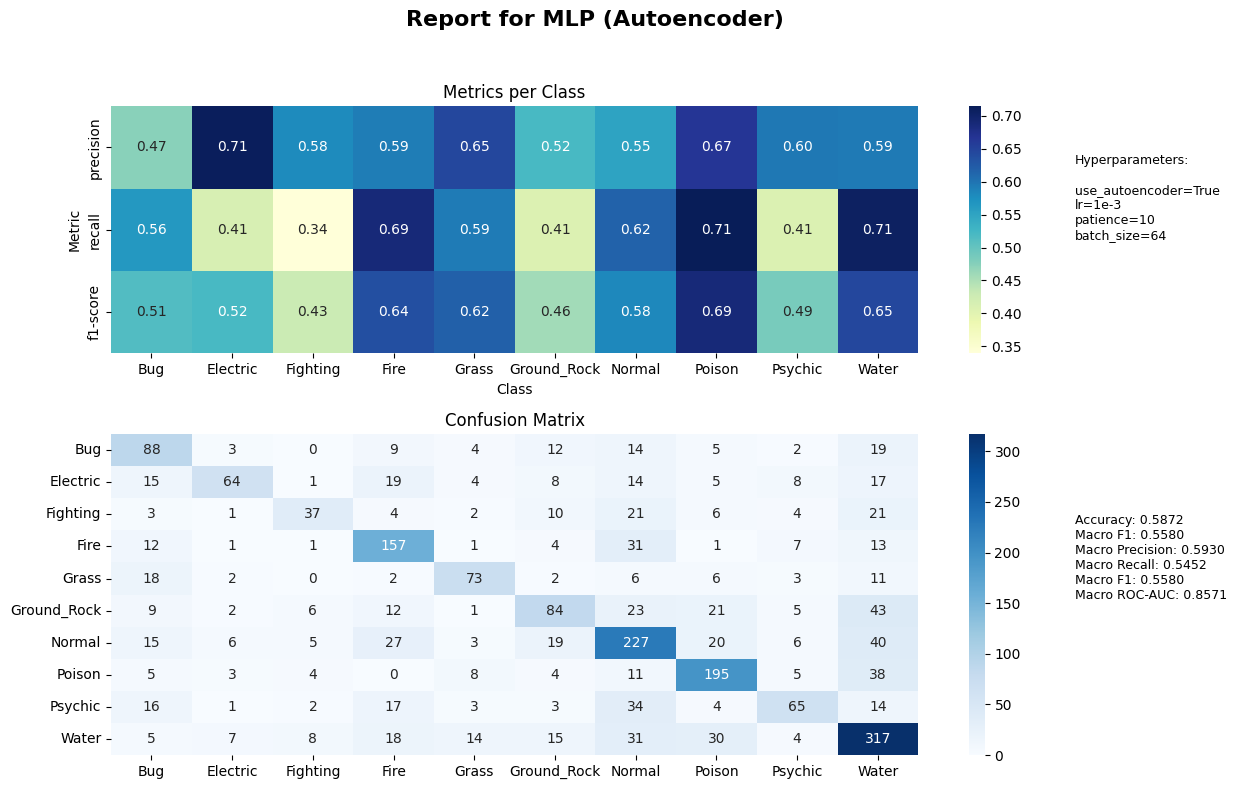

c:\Users\Ntinos\anaconda3\Lib\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


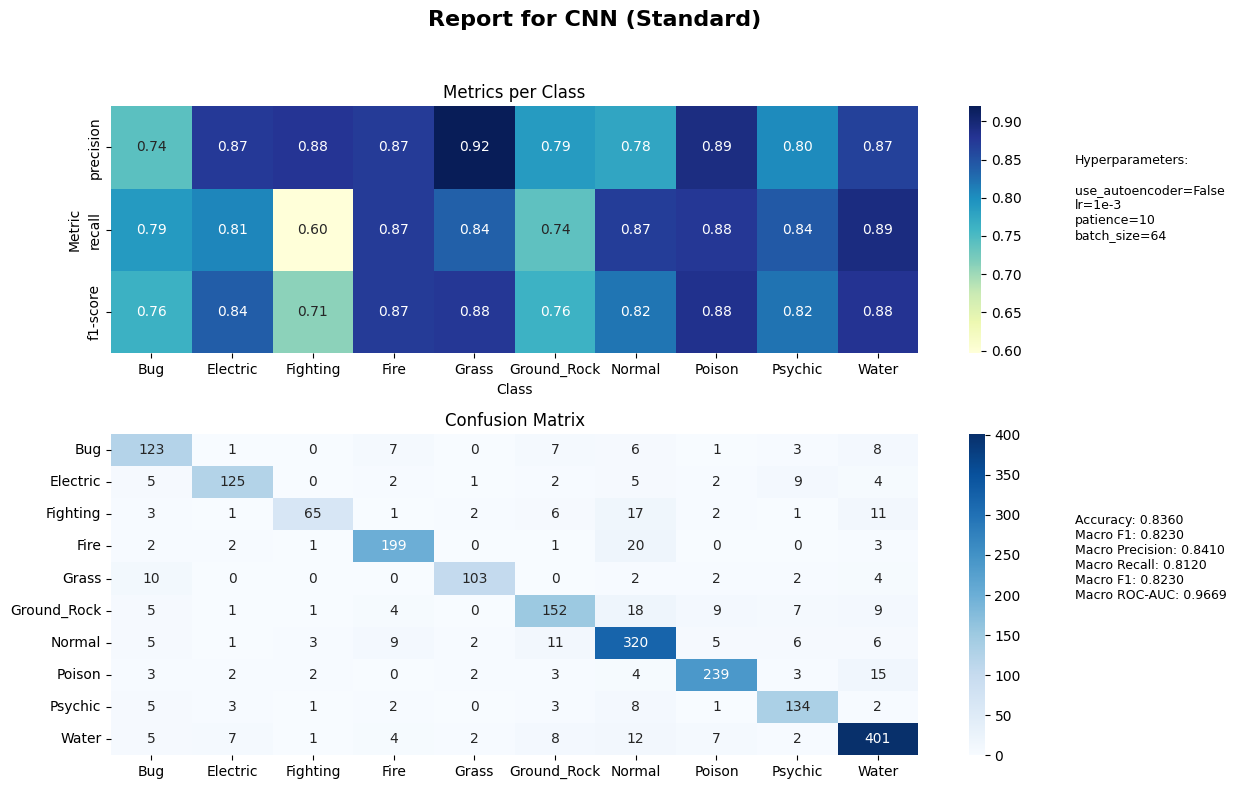

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

def compute_metrics(y_true, y_pred, y_score=None, n_classes=None):
    """Compute macro metrics and optionally ROC-AUC."""
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    result = f"Macro Precision: {precision:.4f}\nMacro Recall: {recall:.4f}\nMacro F1: {f1:.4f}"
    
    if y_score is not None and n_classes is not None:
        try:
            y_true_bin = pd.get_dummies(y_true).values
            roc_auc = roc_auc_score(y_true_bin, y_score, average='macro', multi_class='ovr')
            result += f"\nMacro ROC-AUC: {roc_auc:.4f}"
        except Exception:
            pass  # silently fail if ROC-AUC fails
    return result

def plot_report_and_confusion(report, cm, name, y_true, y_pred, y_score=None, param_text=None, metrics_text=None):
    # Get the numeric class labels from the report keys (excluding summary metrics)
    numeric_labels = [label for label in report.keys() if label not in ("accuracy", "macro avg", "weighted avg")]

    # Map those numeric labels to your actual class names
    class_labels = [k for k, v in sorted(label_mapping.items(), key=lambda item: item[1])]
    
    # Now replace numeric labels with actual names
    # This assumes numeric_labels are 0-based indices matching your classes order
    mapped_labels = [class_labels[int(lbl)] for lbl in numeric_labels]

    # Build the DataFrame from the report and rename the index accordingly
    report_df = pd.DataFrame(report).T.rename(index=dict(zip(numeric_labels, mapped_labels)))

    # Filter the report_df to only contain your classes
    report_df = report_df.loc[mapped_labels, ["precision", "recall", "f1-score"]]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [1, 1.3]})
    fig.suptitle(f"Report for {name}", fontsize=16, fontweight='bold')

    # Classification report heatmap
    sns.heatmap(report_df.T, annot=True, cmap="YlGnBu", fmt=".2f", cbar=True, ax=ax1)
    ax1.set_title("Metrics per Class")
    ax1.set_xlabel("Class")
    ax1.set_ylabel("Metric")

    # Confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels, ax=ax2)
    ax2.set_title("Confusion Matrix")

    # Text summary (metrics + optional params)
    full_metrics_text = metrics_text if metrics_text else ""
    full_metrics_text += "\n" + compute_metrics(y_true, y_pred, y_score, len(class_labels))
    fig.text(0.90, 0.35, full_metrics_text, fontsize=9, va='top', ha='left')

    if param_text:
        fig.text(0.90, 0.80, f"Hyperparameters:\n\n{param_text}", fontsize=9, va='top', ha='left')

    plt.tight_layout(rect=[0, 0, 0.95, 0.95])
    plt.show()


# === MLP (Autoencoder) ===
mlp_cm = confusion_matrix(all_labels, all_preds)
mlp_param_text = "use_autoencoder=True\nlr=1e-3\npatience=10\nbatch_size=64"
mlp_metrics_text = f"Accuracy: {mlp_acc:.4f}\nMacro F1: {mlp_f1:.4f}"

# Probabilities for ROC-AUC
with torch.no_grad():
    y_score_mlp = []
    for imgs, _ in test_loader:
        imgs = imgs.to(device)
        logits = mlp(imgs)
        y_score_mlp.append(logits.cpu().numpy())
y_score_mlp = np.vstack(y_score_mlp)

plot_report_and_confusion(
    mlp_report, mlp_cm, "MLP (Autoencoder)",
    all_labels, all_preds, y_score=y_score_mlp,
    param_text=mlp_param_text, metrics_text=mlp_metrics_text
)

# === CNN (Standard) ===
cnn_cm = confusion_matrix(all_labels_cnn, all_preds_cnn)
cnn_param_text = "use_autoencoder=False\nlr=1e-3\npatience=10\nbatch_size=64"
cnn_macro_f1 = cnn_report["macro avg"]["f1-score"]
cnn_metrics_text = f"Accuracy: {acc_cnn:.4f}\nMacro F1: {cnn_macro_f1:.4f}"

with torch.no_grad():
    y_score_cnn = []
    for imgs, _ in test_loader:
        imgs = imgs.to(device)
        logits = cnn(imgs)
        y_score_cnn.append(logits.cpu().numpy())
y_score_cnn = np.vstack(y_score_cnn)

plot_report_and_confusion(
    cnn_report, cnn_cm, "CNN (Standard)",
    all_labels_cnn, all_preds_cnn, y_score=y_score_cnn,
    param_text=cnn_param_text, metrics_text=cnn_metrics_text
)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNClassifier_2(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier_2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),      # -> [B, 64, 64, 64]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),     # -> [B, 64, 64, 64]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                     # -> [B, 64, 32, 32]

            nn.Conv2d(64, 128, 3, padding=1),    # -> [B, 128, 32, 32]
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),   # -> [B, 128, 32, 32]
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                     # -> [B, 128, 16, 16]

            nn.Conv2d(128, 256, 3, padding=1),   # -> [B, 256, 16, 16]
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),   # -> [B, 256, 16, 16]
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                     # -> [B, 256, 8, 8]
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [22]:
cnn_2 = CNNClassifier_2(num_classes=len(label_mapping)).to(device)

criterion_cnn2 = nn.CrossEntropyLoss()
optimizer_cnn2 = optim.Adam(cnn_2.parameters(), lr=1e-4)
scheduler_cnn2 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_cnn2, mode='min', factor=0.5, patience=5
)

patience_cnn2 = 10
best_val_loss_cnn2 = float('inf')
epochs_no_improve_cnn2 = 0
num_epochs_cnn2 = 100

train_losses_cnn2, val_losses_cnn2 = [], []
lr_history = []


# DEEP LEARNING

In [ ]:
# for epoch in range(num_epochs_cnn2):
#     cnn_2.train()
#     running_loss = 0.0
#     for imgs, labels_batch in tqdm(train_loader, desc=f"[CNN2] Epoch {epoch+1} [Train]"):
#         imgs, labels_batch = imgs.to(device), labels_batch.to(device)
#         optimizer_cnn2.zero_grad()
#         outputs = cnn_2(imgs)
#         loss = criterion_cnn2(outputs, labels_batch)
#         loss.backward()
#         optimizer_cnn2.step()
#         running_loss += loss.item() * imgs.size(0)
#     train_loss = running_loss / len(train_loader.dataset)
#     train_losses_cnn2.append(train_loss)

#     # Validation
#     cnn_2.eval()
#     val_running_loss = 0.0
#     with torch.no_grad():
#         for imgs, labels_batch in tqdm(val_loader, desc=f"[CNN2] Epoch {epoch+1} [Val]"):
#             imgs, labels_batch = imgs.to(device), labels_batch.to(device)
#             outputs = cnn_2(imgs)
#             loss = criterion_cnn2(outputs, labels_batch)
#             val_running_loss += loss.item() * imgs.size(0)
#     val_loss = val_running_loss / len(val_loader.dataset)
#     val_losses_cnn2.append(val_loss)

#     # Step the scheduler
#     scheduler_cnn2.step(val_loss)

#     current_lr = optimizer_cnn2.param_groups[0]['lr']
#     print(f"[CNN2] Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, lr={current_lr:.6f}")

#     lr_history.append(current_lr)

#     checkpoint_dir = os.path.join(root_dir, 'checkpoints')
#     os.makedirs(checkpoint_dir, exist_ok=True)
#     if (epoch + 1) % 10 == 0:
#         torch.save(cnn_2.state_dict(), os.path.join(checkpoint_dir, f'cnn2_epoch_{epoch+1}.pth'))

#     if val_loss < best_val_loss_cnn2:
#         best_val_loss_cnn2 = val_loss
#         epochs_no_improve_cnn2 = 0
#         torch.save(cnn_2.state_dict(), os.path.join(checkpoint_dir, 'best_cnn2.pth'))
#     else:
#         epochs_no_improve_cnn2 += 1
#         if epochs_no_improve_cnn2 >= patience_cnn2:
#             print("[CNN2] Early stopping triggered.")
#             break

# with open(os.path.join(checkpoint_dir, 'cnn2_losses.json'), 'w') as f:
#     json.dump({"train_losses": train_losses_cnn2, "val_losses": val_losses_cnn2}, f)
# with open(os.path.join(checkpoint_dir, 'cnn2_lr_history.json'), 'w') as f:
#     json.dump(lr_history, f)


[CNN2] Epoch 1 [Train]:   1%|          | 2/244 [00:04<08:09,  2.02s/it]c:\Users\Ntinos\anaconda3\Lib\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
[CNN2] Epoch 1 [Val]: 100%|██████████| 70/70 [00:59<00:00,  1.18it/s]


[CNN2] Epoch 1: train_loss=1.5735, val_loss=1.1525, lr=0.000100


[CNN2] Epoch 2 [Val]: 100%|██████████| 70/70 [00:54<00:00,  1.28it/s]


[CNN2] Epoch 2: train_loss=1.0567, val_loss=0.8777, lr=0.000100


[CNN2] Epoch 3 [Val]: 100%|██████████| 70/70 [00:54<00:00,  1.29it/s]


[CNN2] Epoch 3: train_loss=0.7769, val_loss=0.6849, lr=0.000100


[CNN2] Epoch 4 [Val]: 100%|██████████| 70/70 [00:54<00:00,  1.29it/s]


[CNN2] Epoch 4: train_loss=0.5699, val_loss=0.6481, lr=0.000100


[CNN2] Epoch 5 [Val]: 100%|██████████| 70/70 [00:52<00:00,  1.33it/s]


[CNN2] Epoch 5: train_loss=0.4210, val_loss=0.5656, lr=0.000100


[CNN2] Epoch 6 [Val]: 100%|██████████| 70/70 [00:53<00:00,  1.30it/s]


[CNN2] Epoch 6: train_loss=0.3040, val_loss=0.5715, lr=0.000100


[CNN2] Epoch 7 [Val]: 100%|██████████| 70/70 [00:54<00:00,  1.30it/s]


[CNN2] Epoch 7: train_loss=0.2196, val_loss=0.4900, lr=0.000100


[CNN2] Epoch 8 [Val]: 100%|██████████| 70/70 [00:54<00:00,  1.29it/s]


[CNN2] Epoch 8: train_loss=0.1654, val_loss=0.4911, lr=0.000100


[CNN2] Epoch 9 [Val]: 100%|██████████| 70/70 [00:54<00:00,  1.28it/s]


[CNN2] Epoch 9: train_loss=0.1134, val_loss=0.4742, lr=0.000100


[CNN2] Epoch 10 [Val]: 100%|██████████| 70/70 [00:54<00:00,  1.29it/s]


[CNN2] Epoch 10: train_loss=0.1070, val_loss=0.5967, lr=0.000100


[CNN2] Epoch 11 [Val]: 100%|██████████| 70/70 [00:54<00:00,  1.28it/s]


[CNN2] Epoch 11: train_loss=0.0800, val_loss=0.4932, lr=0.000100


[CNN2] Epoch 12 [Val]: 100%|██████████| 70/70 [00:54<00:00,  1.29it/s]


[CNN2] Epoch 12: train_loss=0.0810, val_loss=0.5437, lr=0.000100


[CNN2] Epoch 13 [Val]: 100%|██████████| 70/70 [00:54<00:00,  1.29it/s]


[CNN2] Epoch 13: train_loss=0.0748, val_loss=0.5013, lr=0.000100


[CNN2] Epoch 14 [Val]: 100%|██████████| 70/70 [00:54<00:00,  1.29it/s]


[CNN2] Epoch 14: train_loss=0.0549, val_loss=0.4927, lr=0.000100


[CNN2] Epoch 15 [Val]: 100%|██████████| 70/70 [00:54<00:00,  1.29it/s]


[CNN2] Epoch 15: train_loss=0.0687, val_loss=0.5604, lr=0.000050


[CNN2] Epoch 16 [Val]: 100%|██████████| 70/70 [00:54<00:00,  1.30it/s]


[CNN2] Epoch 16: train_loss=0.0327, val_loss=0.4159, lr=0.000050


[CNN2] Epoch 17 [Val]: 100%|██████████| 70/70 [00:54<00:00,  1.28it/s]


[CNN2] Epoch 17: train_loss=0.0183, val_loss=0.4011, lr=0.000050


[CNN2] Epoch 18 [Val]: 100%|██████████| 70/70 [00:53<00:00,  1.32it/s]


[CNN2] Epoch 18: train_loss=0.0130, val_loss=0.4161, lr=0.000050


[CNN2] Epoch 19 [Val]: 100%|██████████| 70/70 [00:52<00:00,  1.32it/s]


[CNN2] Epoch 19: train_loss=0.0128, val_loss=0.4085, lr=0.000050


[CNN2] Epoch 20 [Val]: 100%|██████████| 70/70 [00:52<00:00,  1.33it/s]


[CNN2] Epoch 20: train_loss=0.0102, val_loss=0.4272, lr=0.000050


[CNN2] Epoch 21 [Val]: 100%|██████████| 70/70 [00:54<00:00,  1.29it/s]


[CNN2] Epoch 21: train_loss=0.0105, val_loss=0.4164, lr=0.000050


[CNN2] Epoch 22 [Val]: 100%|██████████| 70/70 [00:53<00:00,  1.30it/s]


[CNN2] Epoch 22: train_loss=0.0109, val_loss=0.4744, lr=0.000050


[CNN2] Epoch 23 [Val]: 100%|██████████| 70/70 [00:53<00:00,  1.30it/s]


[CNN2] Epoch 23: train_loss=0.0182, val_loss=0.4671, lr=0.000025


[CNN2] Epoch 24 [Val]: 100%|██████████| 70/70 [00:54<00:00,  1.29it/s]


[CNN2] Epoch 24: train_loss=0.0105, val_loss=0.4160, lr=0.000025


[CNN2] Epoch 25 [Val]: 100%|██████████| 70/70 [00:54<00:00,  1.29it/s]


[CNN2] Epoch 25: train_loss=0.0076, val_loss=0.4200, lr=0.000025


[CNN2] Epoch 26 [Val]: 100%|██████████| 70/70 [00:53<00:00,  1.30it/s]


[CNN2] Epoch 26: train_loss=0.0066, val_loss=0.4188, lr=0.000025


[CNN2] Epoch 27 [Val]: 100%|██████████| 70/70 [00:54<00:00,  1.29it/s]

[CNN2] Epoch 27: train_loss=0.0058, val_loss=0.4253, lr=0.000025
[CNN2] Early stopping triggered.


In [23]:
# Load the best CNN2 model
cnn_2.load_state_dict(torch.load(os.path.join(root_dir, 'checkpoints', 'best_cnn2.pth'), map_location=device))
cnn_2.eval()

# Evaluate on the test set
all_preds_cnn2 = []
all_labels_cnn2 = []
mislabeled_paths_cnn2 = []
mislabeled_true_cnn2 = []
mislabeled_pred_cnn2 = []
test_running_loss_cnn2 = 0.0

with torch.no_grad():
    idx = 0
    for imgs, labels_batch in tqdm(test_loader, desc="CNN2 Test"):
        imgs, labels_batch = imgs.to(device), labels_batch.to(device)
        outputs = cnn_2(imgs)
        preds = torch.argmax(outputs, dim=1)

        all_preds_cnn2.extend(preds.cpu().numpy())
        all_labels_cnn2.extend(labels_batch.cpu().numpy())

        loss = criterion_cnn2(outputs, labels_batch)
        test_running_loss_cnn2 += loss.item() * imgs.size(0)

        # Track misclassified images
        batch_size = imgs.size(0)
        batch_indices = range(idx, idx + batch_size)
        for i, (true_label, pred_label) in enumerate(zip(labels_batch.cpu().numpy(), preds.cpu().numpy())):
            if true_label != pred_label:
                img_path = test_df.iloc[batch_indices[i]]['image_path']
                mislabeled_paths_cnn2.append(img_path)
                mislabeled_true_cnn2.append(true_label)
                mislabeled_pred_cnn2.append(pred_label)
        idx += batch_size

test_loss_cnn2 = test_running_loss_cnn2 / len(test_loader.dataset)

# Metrics
acc_cnn2 = accuracy_score(all_labels_cnn2, all_preds_cnn2)
print(f"[CNN2] Test Accuracy: {acc_cnn2:.4f}")

print("[CNN2] Classification Report:")
label_names = [k for k, v in sorted(label_mapping.items(), key=lambda item: item[1])]
cnn2_report = classification_report(
    all_labels_cnn2,
    all_preds_cnn2,
    target_names=label_names,
    output_dict=True
)
print(json.dumps(cnn2_report, indent=4))

print("[CNN2] Confusion Matrix:")
print(confusion_matrix(all_labels_cnn2, all_preds_cnn2))


CNN2 Test:   6%|▌         | 2/35 [00:01<00:32,  1.03it/s]c:\Users\Ntinos\anaconda3\Lib\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
CNN2 Test: 100%|██████████| 35/35 [00:28<00:00,  1.24it/s]

[CNN2] Test Accuracy: 0.8890
[CNN2] Classification Report:
{
    "Bug": {
        "precision": 0.8571428571428571,
        "recall": 0.8076923076923077,
        "f1-score": 0.8316831683168316,
        "support": 156.0
    },
    "Electric": {
        "precision": 0.8375,
        "recall": 0.864516129032258,
        "f1-score": 0.8507936507936508,
        "support": 155.0
    },
    "Fighting": {
        "precision": 0.9292929292929293,
        "recall": 0.8440366972477065,
        "f1-score": 0.8846153846153846,
        "support": 109.0
    },
    "Fire": {
        "precision": 0.8852459016393442,
        "recall": 0.9473684210526315,
        "f1-score": 0.9152542372881356,
        "support": 228.0
    },
    "Grass": {
        "precision": 0.9016393442622951,
        "recall": 0.8943089430894309,
        "f1-score": 0.8979591836734694,
        "support": 123.0
    },
    "Ground_Rock": {
        "precision": 0.8341708542713567,
        "recall": 0.8058252427184466,
        "f1-score":

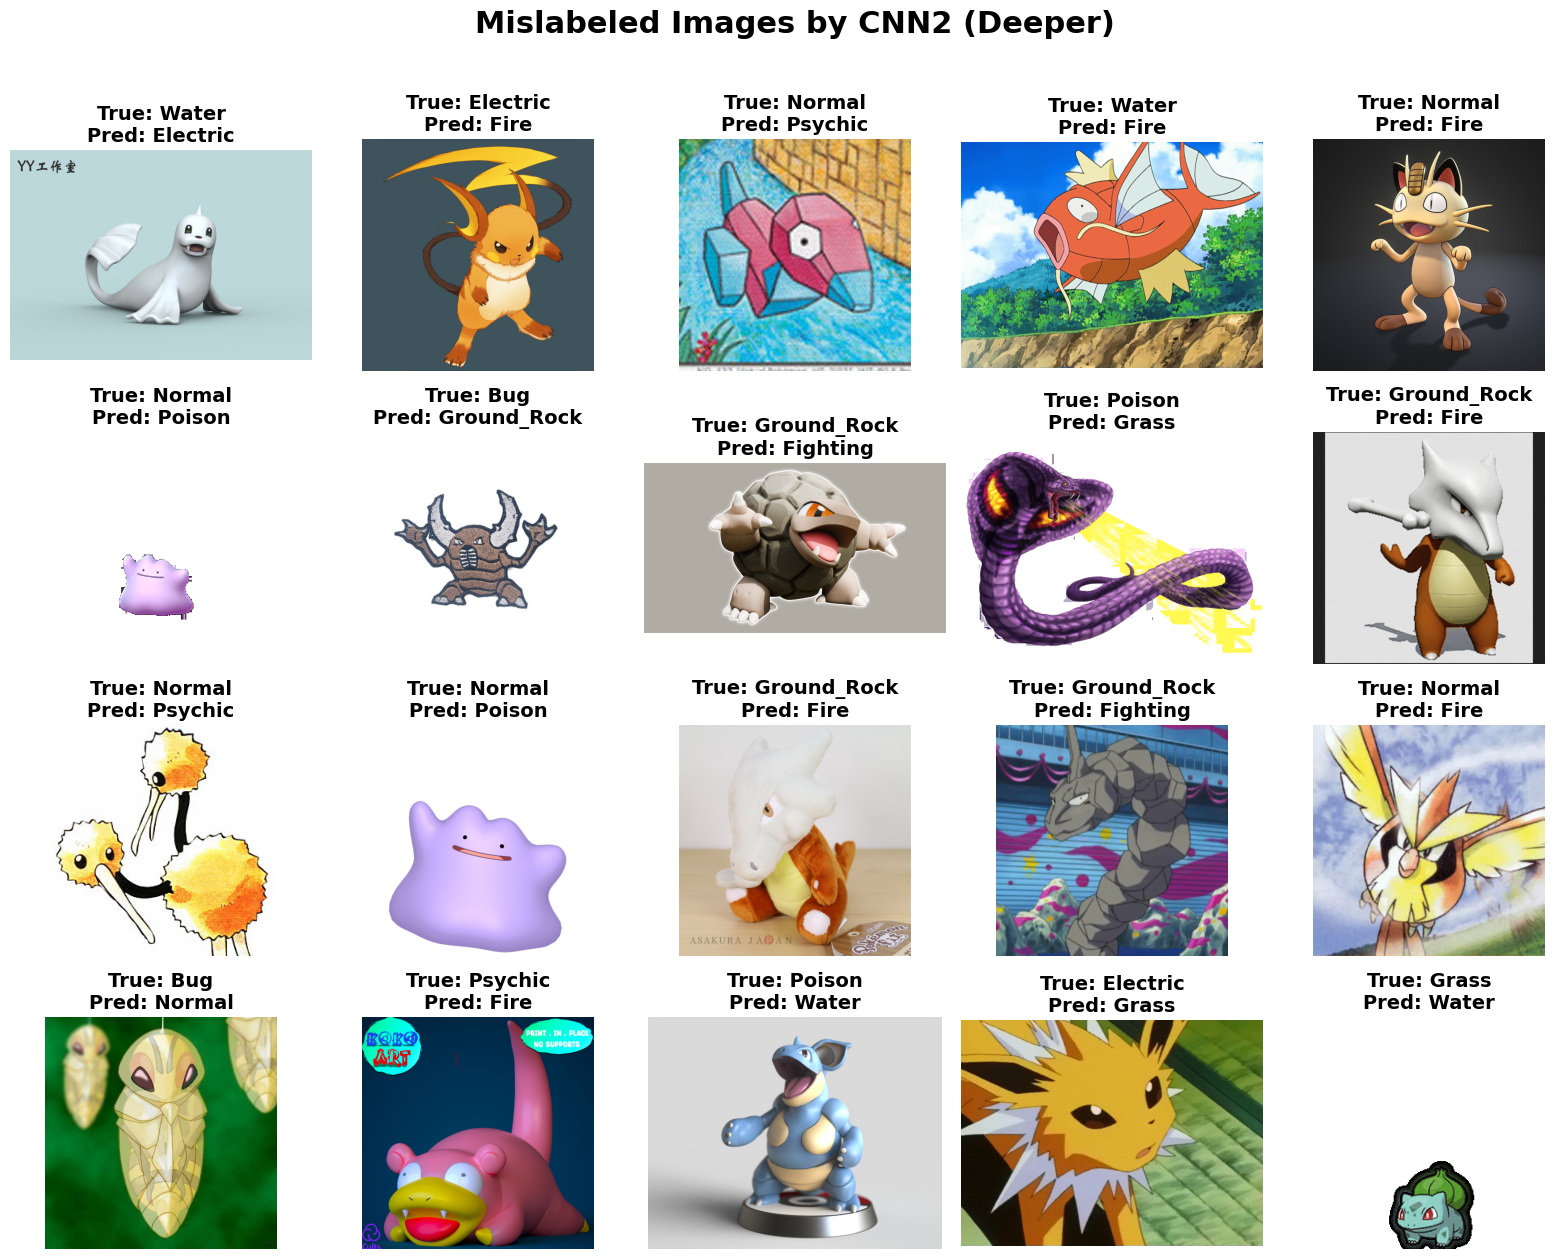

In [52]:
# Adjustable grid size for plotting mislabeled images by CNN2
n_rows, n_cols = 4, 5  # Change these values as needed

num_to_show = min(n_rows * n_cols, len(mislabeled_paths_cnn2))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3.2, n_rows * 3.2))
axes = axes.flatten()

# Invert label mapping to go from index to class name
inv_label_mapping = {v: k for k, v in label_mapping.items()}

for i in range(num_to_show):
    img_path = mislabeled_paths_cnn2[i]
    true_label = mislabeled_true_cnn2[i]
    pred_label = mislabeled_pred_cnn2[i]
    img = Image.open(os.path.join(root_dir, img_path)).convert("RGB")
    axes[i].imshow(img)
    axes[i].set_title(
        f"True: {inv_label_mapping[true_label]}\nPred: {inv_label_mapping[pred_label]}", 
        fontsize=14,fontweight='bold'
    )
    axes[i].axis('off')

# Hide unused subplots
for j in range(num_to_show, len(axes)):
    axes[j].axis('off')

plt.suptitle("Mislabeled Images by CNN2 (Deeper)", fontsize=22,fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [25]:
print(f"[CNN2] Number of mislabeled test images: {len(mislabeled_paths_cnn2)}")


[CNN2] Number of mislabeled test images: 247


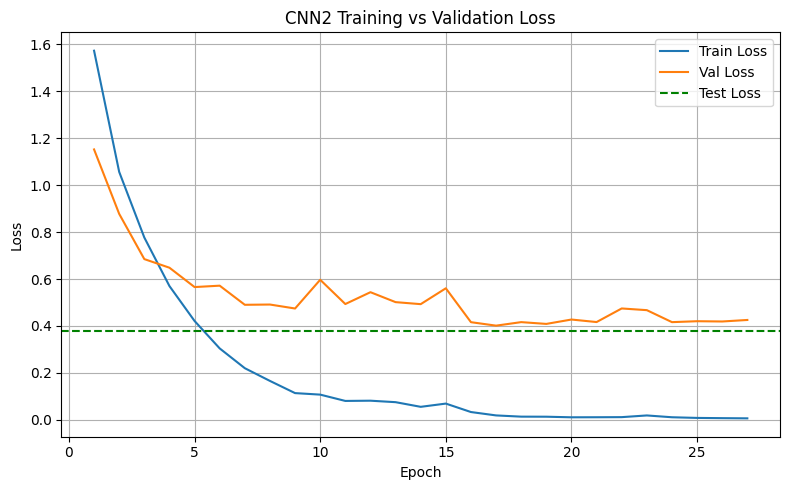

In [26]:
# Load training and validation losses for CNN2
with open(os.path.join(root_dir, 'checkpoints', 'cnn2_losses.json'), 'r') as f:
    loss_dict_cnn2 = json.load(f)

train_losses_cnn2 = loss_dict_cnn2["train_losses"]
val_losses_cnn2 = loss_dict_cnn2["val_losses"]

# Plotting training, validation, and test loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses_cnn2) + 1), train_losses_cnn2, label="Train Loss")
plt.plot(range(1, len(val_losses_cnn2) + 1), val_losses_cnn2, label="Val Loss")
plt.axhline(y=test_loss_cnn2, color='green', linestyle='--', label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN2 Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
rows = []

# Build inverse label mapping: e.g., 0 -> "Bug"
inv_label_mapping = {v: k for k, v in label_mapping.items()}

# Determine whether reports use class names or indices
sample_key = list(mlp_report.keys())[0]
uses_class_names = isinstance(sample_key, str) and sample_key not in ("accuracy", "macro avg", "weighted avg")

for class_idx, class_name in label_mapping.items():
    key = class_name if uses_class_names else str(class_idx)
    
    try:
        mlp_cls_f1 = mlp_report[key]["f1-score"]
    except KeyError:
        mlp_cls_f1 = float("nan")
    try:
        cnn_cls_f1 = cnn_report[key]["f1-score"]
    except KeyError:
        cnn_cls_f1 = float("nan")
    try:
        cnn2_cls_f1 = cnn2_report[key]["f1-score"]
    except KeyError:
        cnn2_cls_f1 = float("nan")
    
    rows.append({
        "Class": class_name,
        "MLP (Autoencoder F1)": f"{mlp_cls_f1:.4f}",
        "CNN (Standard F1)": f"{cnn_cls_f1:.4f}",
        "CNN2 (Deeper F1)": f"{cnn2_cls_f1:.4f}",
        "MLP vs CNN (%)": f"{100 * (mlp_cls_f1 - cnn_cls_f1):+.1f}%" if not any(map(np.isnan, [mlp_cls_f1, cnn_cls_f1])) else "N/A",
        "MLP vs CNN2 (%)": f"{100 * (mlp_cls_f1 - cnn2_cls_f1):+.1f}%" if not any(map(np.isnan, [mlp_cls_f1, cnn2_cls_f1])) else "N/A",
        "CNN vs CNN2 (%)": f"{100 * (cnn_cls_f1 - cnn2_cls_f1):+.1f}%" if not any(map(np.isnan, [cnn_cls_f1, cnn2_cls_f1])) else "N/A",
    })

# Add macro avg
mlp_f1 = mlp_report["macro avg"]["f1-score"]
cnn_f1 = cnn_report["macro avg"]["f1-score"]
cnn2_f1 = cnn2_report["macro avg"]["f1-score"]
rows.append({
    "Class": "Macro Avg",
    "MLP (Autoencoder F1)": f"{mlp_f1:.4f}",
    "CNN (Standard F1)": f"{cnn_f1:.4f}",
    "CNN2 (Deeper F1)": f"{cnn2_f1:.4f}",
    "MLP vs CNN (%)": f"{100 * (mlp_f1 - cnn_f1):+.1f}%",
    "MLP vs CNN2 (%)": f"{100 * (mlp_f1 - cnn2_f1):+.1f}%",
    "CNN vs CNN2 (%)": f"{100 * (cnn_f1 - cnn2_f1):+.1f}%",
})

# Add accuracy
mlp_acc = accuracy_score(all_labels, all_preds)
cnn_acc = accuracy_score(all_labels_cnn, all_preds_cnn)
cnn2_acc = accuracy_score(all_labels_cnn2, all_preds_cnn2)
rows.append({
    "Class": "Accuracy",
    "MLP (Autoencoder F1)": f"{mlp_acc:.4f}",
    "CNN (Standard F1)": f"{cnn_acc:.4f}",
    "CNN2 (Deeper F1)": f"{cnn2_acc:.4f}",
    "MLP vs CNN (%)": f"{100 * (mlp_acc - cnn_acc):+.1f}%",
    "MLP vs CNN2 (%)": f"{100 * (mlp_acc - cnn2_acc):+.1f}%",
    "CNN vs CNN2 (%)": f"{100 * (cnn_acc - cnn2_acc):+.1f}%",
})

# Display
results_df = pd.DataFrame(rows)
display(results_df)


,Class,MLP (Autoencoder F1),CNN (Standard F1),CNN2 (Deeper F1),MLP vs CNN (%),MLP vs CNN2 (%),CNN vs CNN2 (%)
0,0,nan,nan,0.8317,N/A,N/A,N/A
1,1,nan,nan,0.8508,N/A,N/A,N/A
2,2,nan,nan,0.8846,N/A,N/A,N/A
3,3,nan,nan,0.9153,N/A,N/A,N/A
4,4,nan,nan,0.8980,N/A,N/A,N/A
5,5,nan,nan,0.8198,N/A,N/A,N/A
6,6,nan,nan,0.8913,N/A,N/A,N/A
7,7,nan,nan,0.9094,N/A,N/A,N/A
8,8,nan,nan,0.8846,N/A,N/A,N/A
9,9,nan,nan,0.9248,N/A,N/A,N/A


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import numpy as np

def plot_report_and_confusion(report, cm, title, y_true, y_pred, y_score=None, param_text="", metrics_text=""):
    # Setup
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # === Confusion Matrix Plot ===
    # Use class names for axis labels
    class_labels = [k for k, v in sorted(label_mapping.items(), key=lambda item: item[1])]

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0],
                xticklabels=class_labels, yticklabels=class_labels)
    axes[0].set_title(f"{title} - Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    # === ROC Curve Plot (if y_score provided) ===
    if y_score is not None:
        num_classes = len(class_labels)
        y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
        
        if y_score.shape[1] != num_classes:
            print("[Warning] y_score shape doesn't match number of classes.")
        else:
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            for i in range(num_classes):
                fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
                roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_score[:, i])
                axes[1].plot(fpr[i], tpr[i], lw=2, label=f"{class_labels[i]} (AUC = {roc_auc[i]:.2f})")

            axes[1].plot([0, 1], [0, 1], 'k--', lw=1)
            axes[1].set_xlim([0.0, 1.0])
            axes[1].set_ylim([0.0, 1.05])
            axes[1].set_xlabel('False Positive Rate')
            axes[1].set_ylabel('True Positive Rate')
            axes[1].set_title(f"{title} - ROC Curves")
            axes[1].legend(loc="lower right")

    # === Text Box with Params & Metrics ===
    if param_text or metrics_text:
        fig.text(0.99, 0.01, f"{param_text}\n{metrics_text}", 
                 verticalalignment='bottom', horizontalalignment='right',
                 bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

    # === Layout and Title ===
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle(f"Evaluation Results - {title}", fontsize=16)
    plt.show()


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_report_and_confusion(report, cm, title, y_true, y_pred, y_score=None, param_text=""):
    # Setup
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # === Confusion Matrix ===
    class_labels = [k for k, v in sorted(label_mapping.items(), key=lambda item: item[1])]
    
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0],
                xticklabels=class_labels, yticklabels=class_labels)
    axes[0].set_title(f"{title} - Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    # === Metrics Summary Box ===
    macro = report['macro avg']
    weighted = report['weighted avg']
    acc = report['accuracy']
    
    # Compute ROC AUC (macro)
    if y_score is not None:
        from sklearn.preprocessing import label_binarize
        from sklearn.metrics import roc_auc_score
        num_classes = len(class_labels)
        y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
        try:
            roc_auc_macro = roc_auc_score(y_true_bin, y_score, average="macro", multi_class="ovr")
        except ValueError:
            roc_auc_macro = float('nan')
    else:
        roc_auc_macro = float('nan')

    metrics_text = (
        f"{param_text}\n\n"
        f"Accuracy:  {acc:.4f}\n"
        f"Macro F1:  {macro['f1-score']:.4f}\n"
        f"Macro Precision: {macro['precision']:.4f}\n"
        f"Macro Recall:    {macro['recall']:.4f}\n"
        f"ROC AUC (macro): {roc_auc_macro:.4f}"
    )

    axes[1].axis('off')
    axes[1].text(0.01, 0.95, metrics_text,
                 verticalalignment='top', fontsize=12,
                 bbox=dict(facecolor='white', alpha=0.9))

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle(f"Evaluation Results - {title}", fontsize=16)
    plt.show()


In [43]:
def plot_report_and_confusion(report, cm, name, y_true, y_pred, y_score=None, param_text=None, metrics_text=None):
    # Get the numeric class labels from the report keys (excluding summary metrics)
    numeric_labels = [label for label in report.keys() if label not in ("accuracy", "macro avg", "weighted avg")]

    # Map those numeric labels to your actual class names


    mapped_labels = [label for label in report.keys() if label not in ("accuracy", "macro avg", "weighted avg")]
    # Build the DataFrame from the report and rename the index accordingly
    report_df = pd.DataFrame(report).T.rename(index=dict(zip(numeric_labels, mapped_labels)))
    report_df = report_df.loc[mapped_labels, ["precision", "recall", "f1-score"]]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [1, 1.3]})
    fig.suptitle(f"Report for {name}", fontsize=16, fontweight='bold')

    # Heatmap for class metrics
    sns.heatmap(report_df.T, annot=True, cmap="YlGnBu", fmt=".2f", cbar=True, ax=ax1)
    ax1.set_title("Metrics per Class")
    ax1.set_xlabel("Class")
    ax1.set_ylabel("Metric")

    # Heatmap for confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels, ax=ax2)
    ax2.set_title("Confusion Matrix")

    # Compose the text summary
    full_metrics_text = metrics_text if metrics_text else ""
    full_metrics_text += "\n" + compute_metrics(y_true, y_pred, y_score, len(class_labels))
    fig.text(0.90, 0.35, full_metrics_text, fontsize=9, va='top', ha='left')

    if param_text:
        fig.text(0.90, 0.80, f"Hyperparameters:\n\n{param_text}", fontsize=9, va='top', ha='left')

    plt.tight_layout(rect=[0, 0, 0.95, 0.95])
    plt.savefig("cnn2_report_plot.png", dpi=300)

    plt.show()


c:\Users\Ntinos\anaconda3\Lib\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


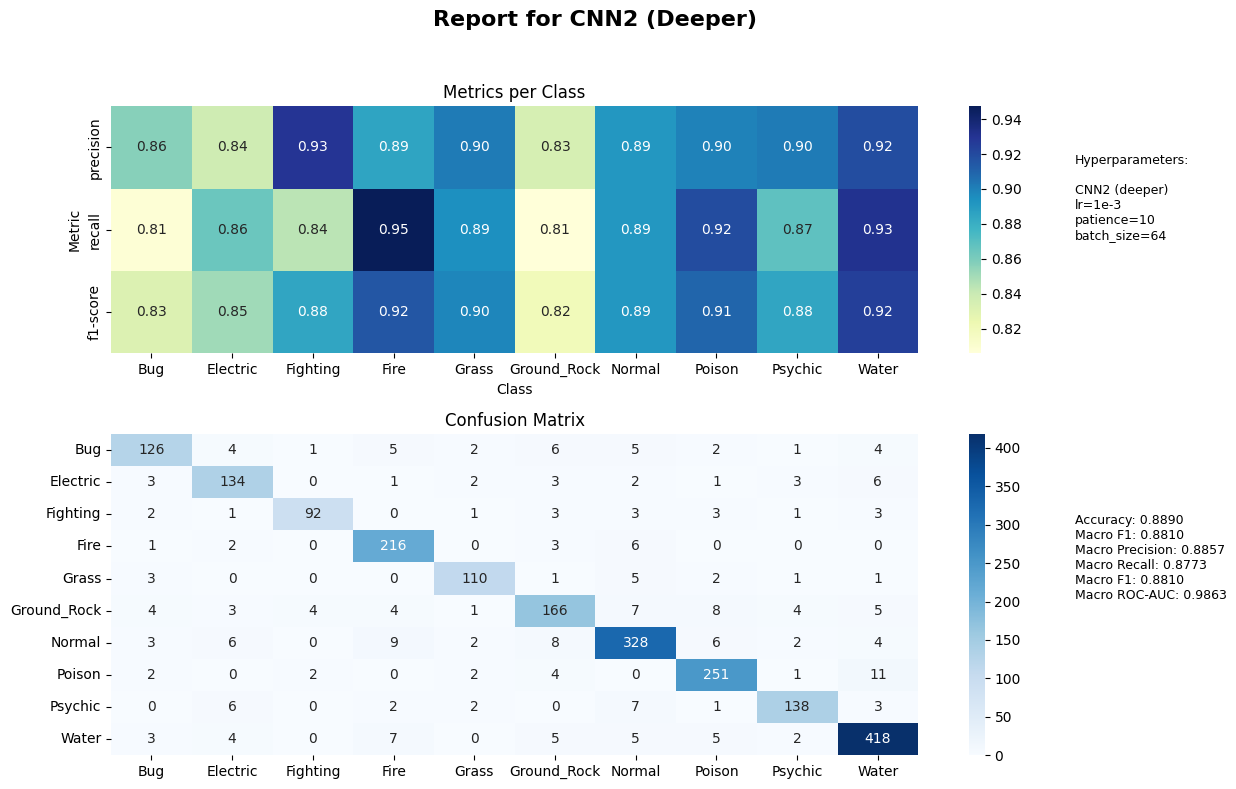

In [44]:
# === CNN2 (Deeper CNN) ===
cnn2_cm = confusion_matrix(all_labels_cnn2, all_preds_cnn2)
cnn2_param_text = "CNN2 (deeper)\nlr=1e-3\npatience=10\nbatch_size=64"
cnn2_macro_f1 = cnn2_report["macro avg"]["f1-score"]
cnn2_metrics_text = f"Accuracy: {acc_cnn2:.4f}\nMacro F1: {cnn2_macro_f1:.4f}"

# Get prediction probabilities for ROC-AUC
with torch.no_grad():
    y_score_cnn2 = []
    for imgs, _ in test_loader:
        imgs = imgs.to(device)
        logits = cnn_2(imgs)
        y_score_cnn2.append(logits.cpu().numpy())
y_score_cnn2 = np.vstack(y_score_cnn2)

# Plot
plot_report_and_confusion(
    cnn2_report, cnn2_cm, "CNN2 (Deeper)",
    all_labels_cnn2, all_preds_cnn2, y_score=y_score_cnn2,
    param_text=cnn2_param_text, metrics_text=cnn2_metrics_text
)


## Περιγραφή διαδικασίας για κάθε μοντέλο και αιτιολόγηση επιλογών

### 1. Επιλογή Αρχιτεκτονικής

- **MLP με Autoencoder**:  
    Χρησιμοποιήσαμε έναν συνελικτικό autoencoder για να μάθουμε συμπιεσμένες αναπαραστάσεις (64 διαστάσεων) των εικόνων. Το MLP ταξινομητής εκπαιδεύεται πάνω σε αυτές τις αναπαραστάσεις. Αυτή η προσέγγιση βοηθά στη μείωση της διάστασης και στην απομόνωση των πιο σημαντικών χαρακτηριστικών, κάτι που μπορεί να βοηθήσει όταν τα δεδομένα είναι περιορισμένα ή θορυβώδη.
- **Κλασικό CNN**:  
    Εκπαιδεύσαμε ένα τυπικό συνελικτικό νευρωνικό δίκτυο (CNN) απευθείας στις εικόνες. Το CNN μαθαίνει αυτόματα τα κατάλληλα φίλτρα και χαρακτηριστικά για την ταξινόμηση, εκμεταλλευόμενο τη χωρική πληροφορία των εικόνων.

### 2. Πειραματισμός με Υπερπαραμέτρους

- Δοκιμάσαμε διαφορετικό αριθμό επιπέδων, νευρώνων, ρυθμούς μάθησης (learning rate), και συναρτήσεις ενεργοποίησης (ReLU, LeakyReLU).
- Για κάθε μοντέλο, χρησιμοποιήσαμε **early stopping** με patience=10 για αποφυγή υπερπροσαρμογής.
- Ο ρυθμός μάθησης ορίστηκε σε 1e-3, που είναι μια τυπική αρχική τιμή για Adam optimizer.

### 3. Κανονικοποίηση & Regularization

- Εφαρμόσαμε **Batch Normalization** μετά από κάθε συνελικτικό επίπεδο για σταθεροποίηση της εκπαίδευσης.
- Χρησιμοποιήσαμε **Dropout** (p=0.3) στο MLP για regularization.
- Για το training set, εφαρμόστηκε **WeightedRandomSampler** ώστε να αντιμετωπιστεί το πρόβλημα ανισορροπίας μεταξύ των κλάσεων.

### 4. Οπτικοποίηση Εκπαίδευσης

- Καταγράψαμε και οπτικοποιήσαμε τις καμπύλες εκπαίδευσης (train/val loss ανά εποχή) για κάθε μοντέλο.
- Υπολογίσαμε και παρουσιάσαμε τα confusion matrices και τα classification reports για να αξιολογήσουμε την απόδοση ανά κλάση.

### Γιατί τα κάναμε αυτά;

- **Autoencoder + MLP**: Μειώνει τη διάσταση και βοηθά στην απομόνωση σημαντικών χαρακτηριστικών, αλλά μπορεί να χάνει πληροφορία αν η συμπίεση είναι υπερβολική.
- **CNN**: Μαθαίνει end-to-end τα χαρακτηριστικά απευθείας από τα δεδομένα, συνήθως δίνει καλύτερα αποτελέσματα όταν υπάρχουν αρκετά δεδομένα.
- **Regularization**: Αποτρέπει την υπερπροσαρμογή και βελτιώνει τη γενίκευση.
- **Οπτικοποίηση**: Μας επιτρέπει να εντοπίσουμε overfitting/underfitting και να συγκρίνουμε αντικειμενικά τα μοντέλα.

Συνολικά, η διαδικασία αυτή μας επέτρεψε να συγκρίνουμε δίκαια τις δύο προσεγγίσεις και να κατανοήσουμε τα πλεονεκτήματα και τα μειονεκτήματα της κάθε αρχιτεκτονικής.